In [44]:
import math
import requests
from PIL import Image, ImageOps
from io import BytesIO
from string import Template
from SPARQLWrapper import SPARQLWrapper, JSON

In [31]:
def sparqlResultToDict(results):
    rows = []
    for result in results["results"]["bindings"]:
        row = {}
        for key in list(result.keys()):
            row[key] = result[key]["value"]
        rows.append(row)
    return rows

In [32]:
endpoint = 'http://localhost:7776/blazegraph/sparql'
maxItems = 9

In [33]:
dossierQuery = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
SELECT DISTINCT ?subject WHERE {
    BIND(<https://resource.swissartresearch.net/type/1525E0B2-4816-3D3F-AEC8-94BDE16CF0EC> as ?dossierType)
    ?subject crm:P2_has_type ?dossierType .
}"""

In [34]:
itemsQueryTemplate = Template("""
PREFIX rso: <http://www.researchspace.org/ontology/>
PREFIX crmdig: <http://www.ics.forth.gr/isl/CRMdig/>
PREFIX la: <https://linked.art/ns/terms/>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
SELECT ?subject ?image WHERE {
    BIND(<$parent> as ?parent)
    BIND("500," as ?size)
    ?subject crm:P46i_forms_part_of ?parent ;
		crm:P128_carries/la:digitally_shown_by/la:digitally_available_via/la:access_point ?iiif .
  OPTIONAL {
    ?region crmdig:L49_is_primary_area_of ?iiif ;
            rso:boundingBox ?bbox .
  }
  BIND(IF(BOUND(?region), URI(CONCAT(STR(?iiif), "/", STRAFTER(?bbox, "xywh="), "/", ?size, "/0/default.jpg")), URI(CONCAT(STR(?iiif), "/full/", ?size, "/0/default.jpg"))) as ?image)
} LIMIT $limit
""")

In [35]:
itemsQuery = """
PREFIX crm: <http:
"""

In [36]:
sparql = SPARQLWrapper(endpoint)
sparql.setReturnFormat(JSON)

In [37]:
sparql.setQuery(dossierQuery)

In [38]:
dossierResults = sparqlResultToDict(sparql.queryAndConvert())

In [39]:
data = []
for dossier in dossierResults:
    row = {
        'dossier': dossier['subject'],
        'images': []
    }
    query = itemsQueryTemplate.substitute(parent=dossier['subject'], limit=maxItems)
    sparql.setQuery(query)
    images = sparqlResultToDict(sparql.queryAndConvert())
    row['images'] = [d['image'] for d in images]
    data.append(row)

In [64]:
def makeContactSheet(urls, *, cols=3, rows=3, width=500, height=500, margin=0, bgColor=(0,0,0)):
    # Adapted from https://code.activestate.com/recipes/412982-use-pil-to-make-a-contact-sheet-montage-of-images/
    maxWidth = int(width / cols - margin * (cols - 1))
    maxHeight = int(height / rows - margin * (rows - 1))
    imgs = []
    for url in urls:
        try:
            response = requests.get(url)
        except Exception as e:
            print("Could not download",url)
            continue
        img = Image.open(BytesIO(response.content))
        img = ImageOps.fit(img, (maxWidth, maxHeight), Image.ANTIALIAS)
        imgs.append(img)
    
    sheet = Image.new('RGB',(width, height), bgColor)
    for row in range(rows):
        for col in range(cols):
            left = int(col * (maxWidth + margin))
            upper = int(row * (maxHeight + margin))
            try:
                img = imgs.pop(0)
            except:
                break
            sheet.paste(img, (left, upper))
    
    return sheet

3 3


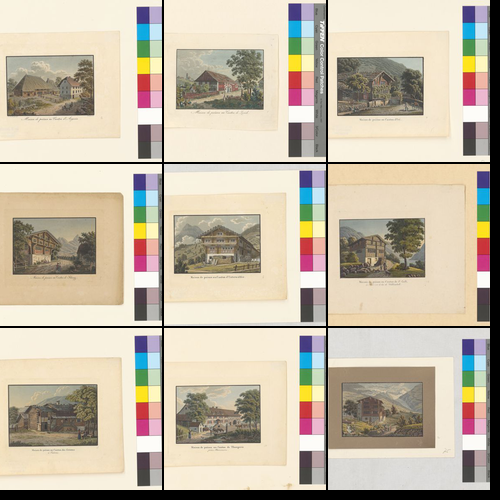

1 1


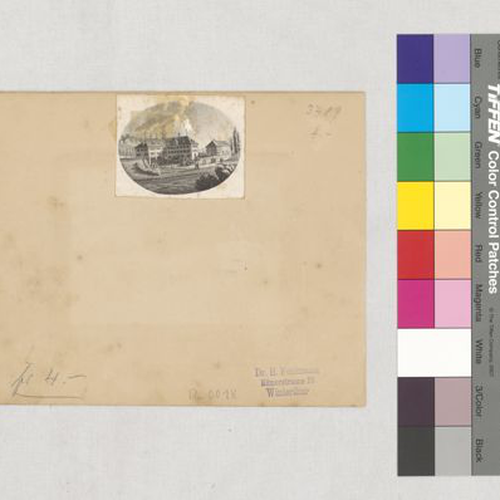

1 1


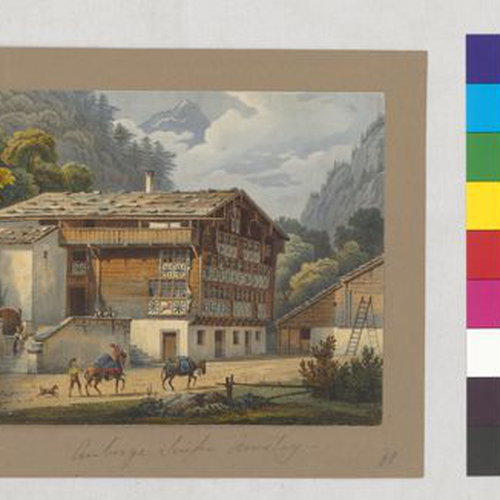

3 3


In [ ]:
for row in data[:12]:
    urls = row['images']
    numRows = math.floor(math.sqrt(len(row['images'])))
    numCols = math.ceil(math.sqrt(len(row['images'])))
    print(numCols, numRows)
    sheet = makeContactSheet(urls, cols=numCols, rows=numRows, margin=2)
    display(sheet)

In [42]:
data[10]

{'dossier': 'https://resource.swissartresearch.net/artwork/CF53F926-914C-35C4-931E-3C6E352DA6A2',
 'images': ['https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1030/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1037/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1216/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1218/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1219/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1255/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1259/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1260/full/500,/0/default.jpg',
  'https://bso-iiif.swissartresearch.net/iiif/2/SFF_D_1261/full/500,/0/default.jpg']}